In [136]:
import os
import cv2
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance

In [137]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [138]:
face_dataset, info = tfds.load('lfw', with_info=True)

In [139]:
cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

In [140]:
def crop_face(image, margin=20, image_size=160):
    faces = cascade.detectMultiScale(image,
                                     scaleFactor=1.1,
                                     minNeighbors=3)
    if len(faces) == 0:
        crop_size = 200
        w, h = image.shape[0:2]
        cropped_image = image[max(int((w - crop_size) / 2), 0):min(int((w + crop_size) / 2), w),
                              max(int((h - crop_size) / 2), 0):min(int((h + crop_size) / 2), h)]
        aligned_image = resize(cropped_image, (image_size, image_size), mode='reflect')
        return aligned_image
    else:
        (x, y, w, h) = faces[0]
        cropped = image[y - margin // 2:y + h + margin // 2,
                        x - margin // 2:x + w + margin // 2,
                        :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        return aligned

In [141]:
def preprocess(image):
    if image.ndim == 4:
        axis = (1, 2, 3)
        size = image[0].size
    elif image.ndim == 3:
        axis = (0, 1, 2)
        size = image.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(image, axis=axis, keepdims=True)
    std  = np.std(image,  axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0 / np.sqrt(size))
    preprocessed_image = (image - mean) / std_adj

    return preprocessed_image

In [142]:
def normalize_embedding(embedding, axis=-1, epsilon=1e-10):
    normalized_embedding = embedding / np.sqrt(np.maximum(np.sum(np.square(embedding),
                                                   axis=axis,
                                                   keepdims=True),
                                            epsilon))
    return normalized_embedding

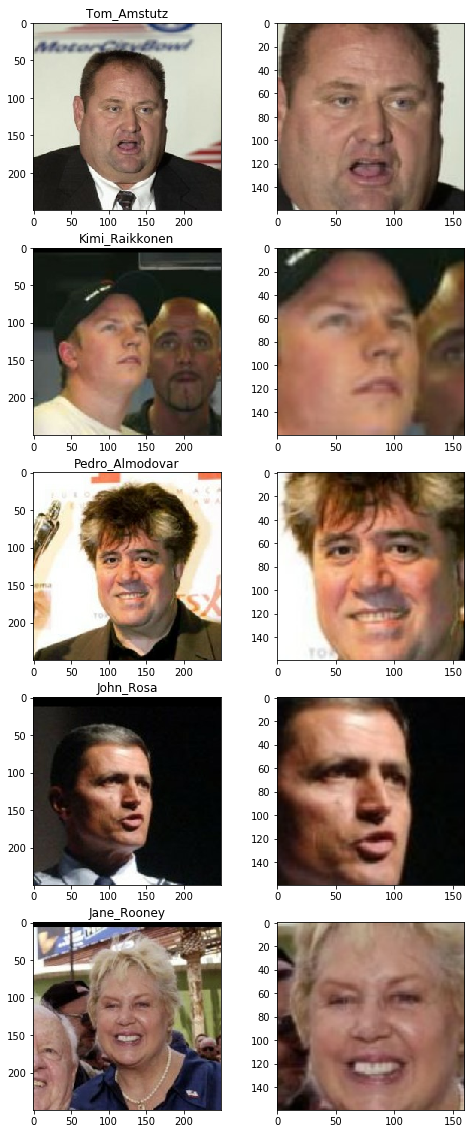

In [143]:
fig, axs = plt.subplots(5, 2, figsize=(8, 20))

for i, example in enumerate(face_dataset['train'].take(5)):
    image = example['image'].numpy()
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(example['label'].numpy().decode("utf-8"))
    axs[i, 1].imshow(crop_face(image))

In [144]:
model = tf.keras.models.load_model('facenet_keras.h5')

In [145]:
def get_distance(image1, image2):
    processed_image1 = preprocess(crop_face(image1)).astype(np.float32)
    processed_image2 = preprocess(crop_face(image2)).astype(np.float32)

    batched_images = np.stack([processed_image1, processed_image2], axis=0)
    batched_embeddings = model(batched_images)
    normalized_embeddings = normalize_embedding(batched_embeddings)
    return distance.euclidean(normalized_embeddings[0], normalized_embeddings[1])

In [146]:
pascal1 = imread('images/pascal1.png')[:, :, :3]
pascal2 = imread('images/pascal2.png')[:, :, :3]
ivan = imread('images/ivan.png')[:, :, :3]

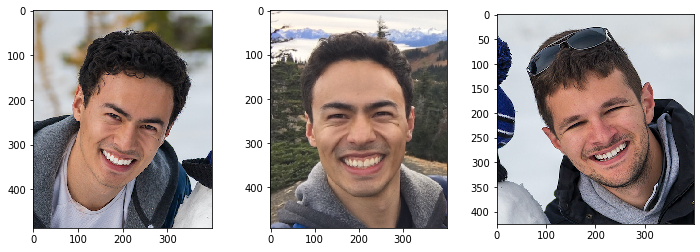

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(pascal1)
axs[1].imshow(pascal2)
axs[2].imshow(ivan)

In [151]:
get_distance(pascal1, pascal2)

0.6503047347068787

In [149]:
get_distance(pascal1, ivan)

1.3819692134857178

In [150]:
get_distance(pascal2, ivan)

1.383406639099121